Northeastern University CV5330 Final Project by Zhengtian Zhang and Yifan Li

# Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#clone YOLOv5 and 
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 13003, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 13003 (delta 0), reused 3 (delta 0), pack-reused 12999
Receiving objects: 100% (13003/13003), 11.85 MiB | 27.21 MiB/s, done.
Resolving deltas: 100% (9039/9039), done.
/content/yolov5
     |████████████████████████████████| 596 kB 23.5 MB/s 
     |████████████████████████████████| 145 kB 37.7 MB/s 
     |████████████████████████████████| 178 kB 77.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.6 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 138 kB 63.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab

# Generate bonding boxes

## Reference set
The reference set contains 7 images for various crowdedness selected manually. To colculate the total number of vehicles detected, ww will use the same model we tranied previously and count the bonding boxes in the resule. The thresholds will also be determined by human.

In [5]:
!python detect.py --weights /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/train1/runs/train/exp/weights/best.pt --img 600 --conf 0.5 --source /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/ref

detect: weights=['/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/train1/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/ref, data=data/coco128.yaml, imgsz=[600, 600], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU

Fusing layers... 
Model summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/7 /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/ref/1.jpg: 320x608 11 Cars, Done. (0.468s)
image 2/7 /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/ref/2.jpg: 320x608 8 Cars, Done. (0.310s)
image 3/7 /content/drive/MyDr

## Prediction set

The prediction set is randomly select 8 images from the same video. The result is counted with the same model we trained.



In [6]:
!python detect.py --weights /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/train1/runs/train/exp/weights/best.pt --img 600 --conf 0.5 --source /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/predict

detect: weights=['/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/train1/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/predict, data=data/coco128.yaml, imgsz=[600, 600], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU

Fusing layers... 
Model summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/predict/1.jpg: 352x608 10 Cars, Done. (0.427s)
image 2/8 /content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/predict/2.jpg: 352x608 13 Cars, Done. (0.427s)
image 3/8 /conte

# Prediction
We are running the same model we tranined with the same settings of confidence threshold of 0.5 and IoU setting of 0.5. This prediction result will be added onto the images with bonding boxes.

## Count for reference set to generate thresholds

In [9]:
import torch

import glob
from IPython.display import Image, display

# Load Model
model_dir = '/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/train1/runs/train/exp/weights/best.pt'
model = torch.hub.load('/content/yolov5','custom', path=model_dir, force_reload=True,source='local')
model.conf = 0.5
model.iou = 0.5
model_predict = model

# Load Images
dir_img = '/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/'
imgs_thres_len = len([img for img in glob.glob('/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/ref/*.jpg')])
img_prediction_len = len([img for img in glob.glob('/content/drive/MyDrive/Northeastern/Spring2022/CS5330/CVproject/image/predict/*.jpg')])
imgs_thres = [dir_img + "ref/"+str(i+1)+'.jpg' for i in range(imgs_thres_len)]
img_prediction = [dir_img + "predict/"+str(i+1)+'.jpg' for i in range(img_prediction_len)]

# Run detection with our model
results_thres = model(imgs_thres)
result_prediction = model_predict(img_prediction)

refCount = [len(results_thres.xyxyn[i])-1 for i in range(len(results_thres.xyxyn))]
predictCount = [len(result_prediction.xyxyn[i])-1 for i in range(len(result_prediction.xyxyn))]
ref_result = ["Img ID: %d - Count %d" %(i+1, refCount[i]) for i in range(imgs_thres_len)]

# Printing references
for item in ref_result:
  print(item)

requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 2 packages updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU

Fusing layers... 
Model summary: 213 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Img ID: 1 - Count 13
Img ID: 2 - Count 7
Img ID: 3 - Count 14
Img ID: 4 - Count 12
Img ID: 5 - Count 11
Img ID: 6 - Count 9
Img ID: 7 - Count 12


## Add conting result for final images

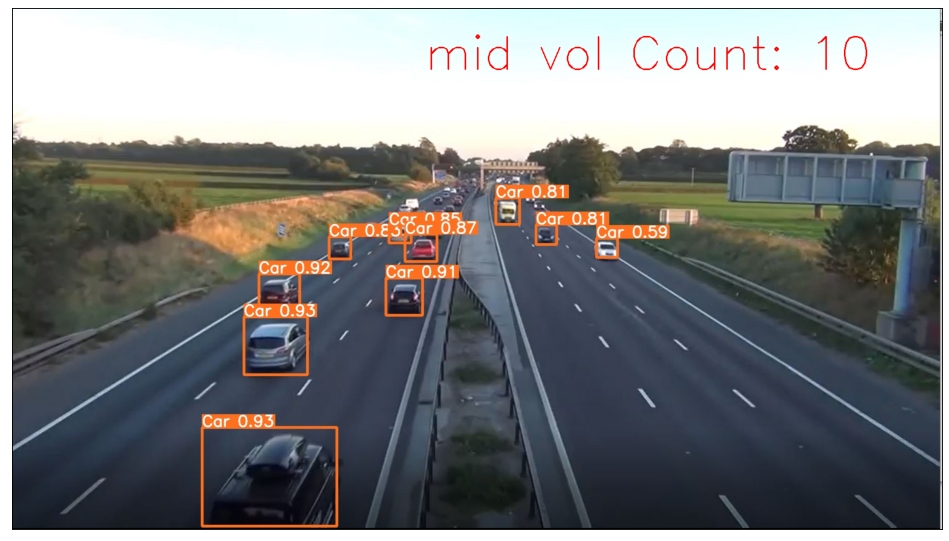

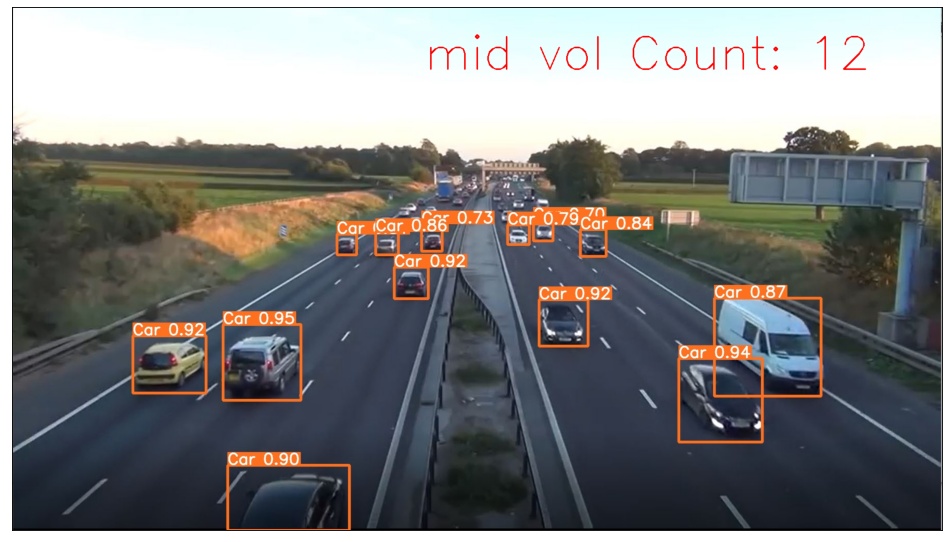

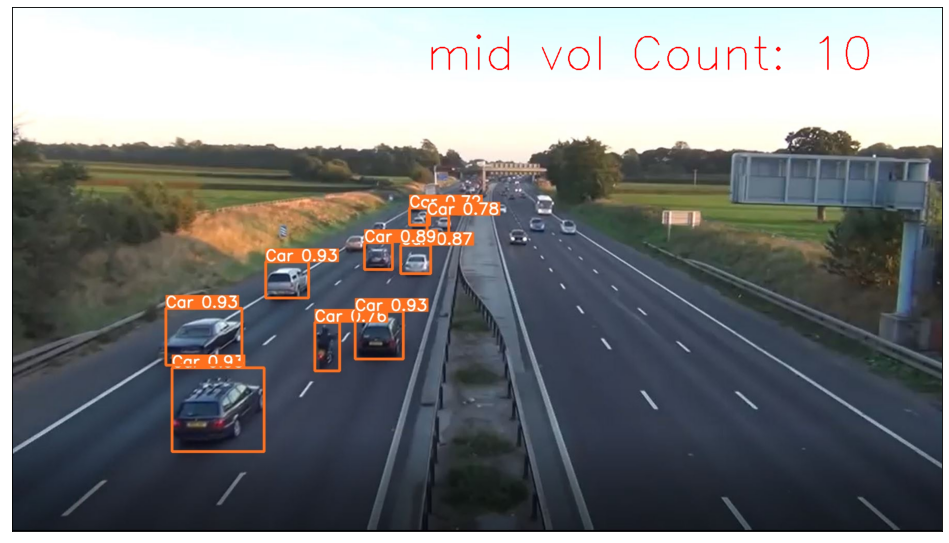

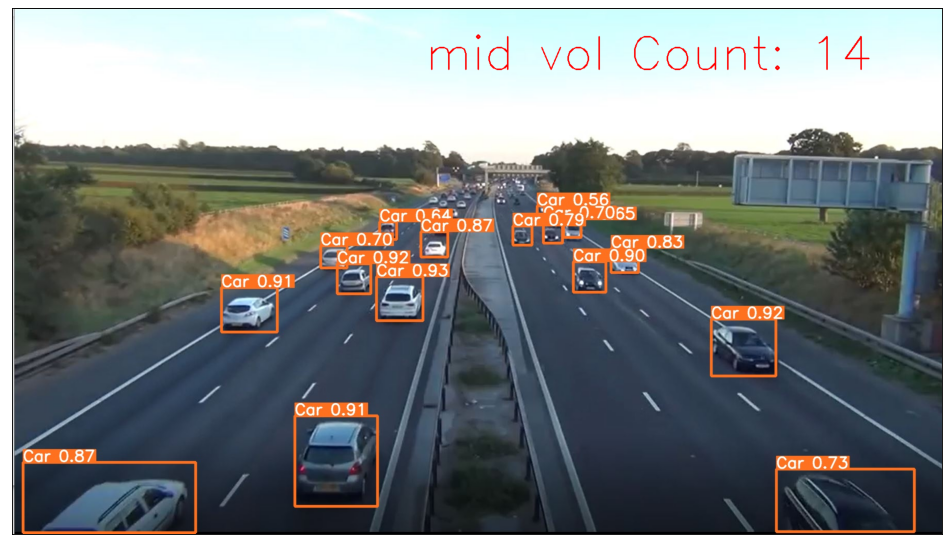

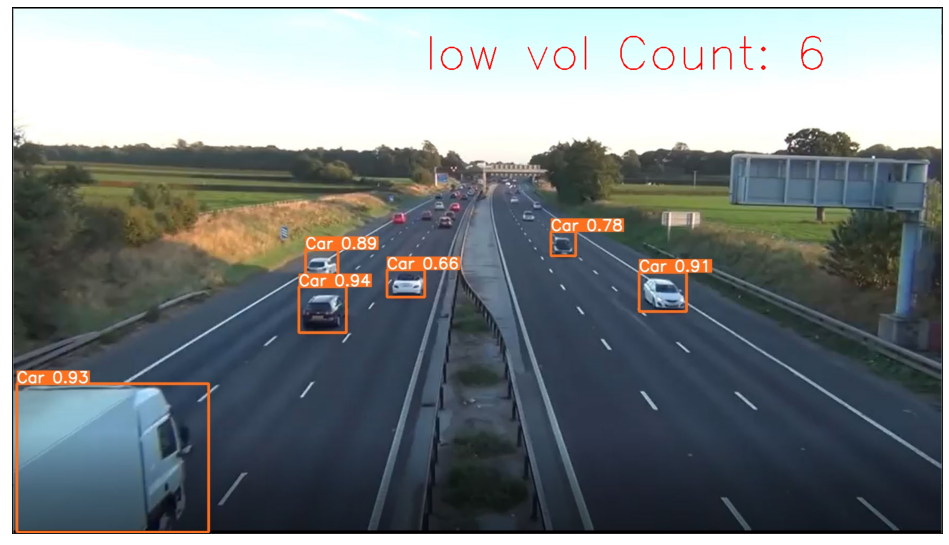

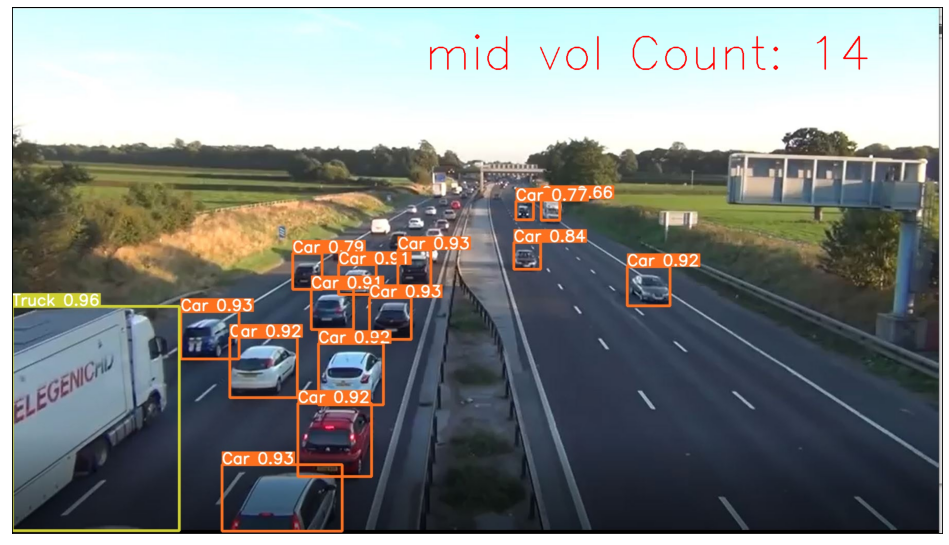

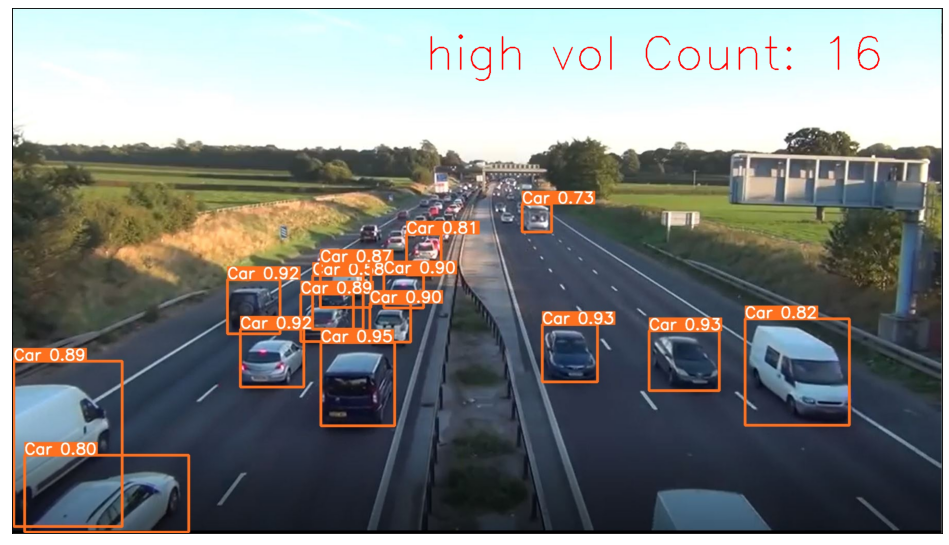

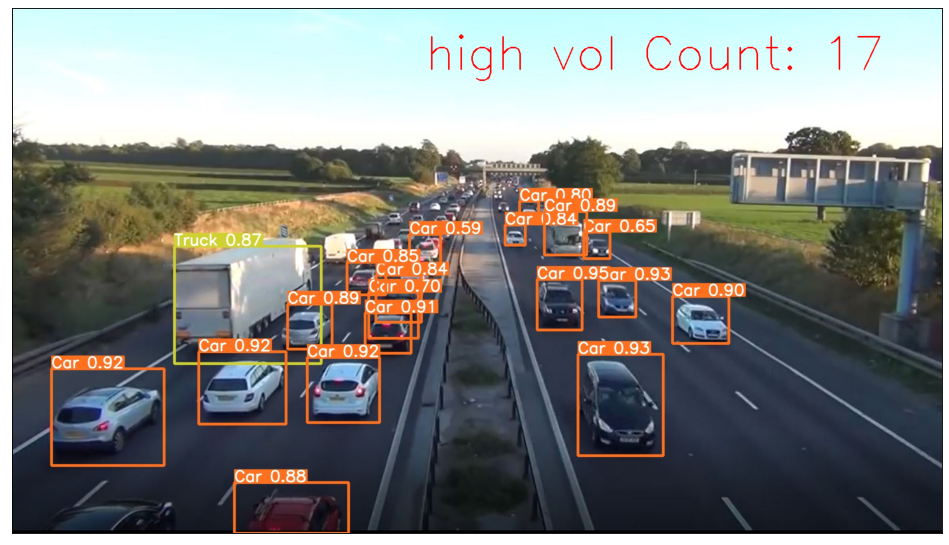

In [8]:
import cv2
from matplotlib import pyplot as plt

# Thresholds are determined arbitrarily bu human judgements.
thres_mid = 10
thres_high = 15

# Helper function for a single case prediction
def predict(predictCount):
  prediction = []
  predictionCnt = []
  
  for cnt in predictCount:
    predictionCnt.append(cnt)
    if cnt < thres_mid:
      prediction.append("low vol")
    elif cnt < thres_high:
      prediction.append("mid vol")
    else:
      prediction.append("high vol")
  return prediction, predictionCnt

prediction_result, prediction_count = predict(predictCount)
dir_img = '/content/yolov5/runs/detect/exp2/'
img_prediction = [dir_img + str(i+1)+'.jpg' for i in range(img_prediction_len)]

# Run prediction for images in prediction set.
for i in range(len(img_prediction)):
  imageName = img_prediction[i]
  img = cv2.imread(imageName)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2.putText(img, prediction_result[i] + " Count: " + str(prediction_count[i]), (800, 120), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 2)
  plt.figure(figsize=(15,9),dpi=80)
  plt.xticks([]), plt.yticks([])
  plt.imshow(img)
  plt.show() 
  
  
